# <center>Classification of Anomalous Time Series</center>

![caption](Anomalous_Time_Series.png)

These days software applications are becoming so complex that understanding their state becoming an issue. There are specialized tools gathering different telemetry like metrics, events, traces and trying to derive application state from the observed signals. Due to high complexity of the environment it is not possible to investigate the issues within reasonable time therefore AI/ML technologies coming to rescue. They can help solving a number of operational problems like root cause analysis, anomaly detection and state prediction.

One of the very important subproblems in this area is classification of time series for further automatic problem detection and root cause analysis.

Usually the time series are the metrics coming from different sources and monitoring tools. The metrics typically are ["Golden signals"](https://landing.google.com/sre/sre-book/chapters/monitoring-distributed-systems/#xref_monitoring_golden-signals), resource utilization (CPU/RAM/Disk), business KPIs (Sales, Latency). 

In this notebook I'd like to demonstrate how anomalous time series can be classified using typical Gradient Boosting tree classifier. This classifier has excellent performance characteristics despite it is notoriously known as desperate overfitter.

The research questions that I'd like to cover are the following:

1. What is time series anomaly, what are the characteristics of anomaly?
2. How to automatically extract features from time series and train a classifier?
3. How to solve class disbalances?
4. How big has to be the sample window to achieve decent classification performance?


In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Including parent path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
import os
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta as td

from sklearn.model_selection import train_test_split

import unittest
import numpy as np
import pandas as pd

from preprocessing.test_common import make_labels, make_series
from preprocessing.helper import TimeseriesHelper
from preprocessing.preprocessing import TimeSeriesPreprocessor
from preprocessing.feature_engineering import TimeSeriesFeatureEngineering
from models.xgboost import XGBoostModel
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
warnings.filterwarnings('ignore')

## 1. Loading the data

I have chosen the [NAB dataset](https://www.kaggle.com/boltzmannbrain/nab) for this research because it is publicly available dataset that contains a representative set of time series with labeled anomalies.

It is very important that the anomalies are labeled by the experts as they provide necessary context and establish necessary casual relationship between change in metric and corresponding issue. 

If the time series is not labeled then it is difficult to conclude if the change in the signal that, for example, has reached a certain threshold or has changed frequency indicating typical changepoint or an actual problem.

In [11]:
helper = TimeseriesHelper()

metric_map = helper.load_multiple_series(
    ["realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv", 
     "realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv",
     "realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv",
     "realAWSCloudwatch/grok_asg_anomaly.csv",
     "realTweets/Twitter_volume_AMZN.csv",
     "realTweets/Twitter_volume_UPS.csv",
     "realTraffic/TravelTime_387.csv",
     "realKnownCause/ec2_request_latency_system_failure.csv",
     "realKnownCause/machine_temperature_system_failure.csv",
     "realKnownCause/ambient_temperature_system_failure.csv"])

## 2. How does anomaly look like and how often it occurs?

Let's now examine the number of metrics from NAB dataset, plot them with corresponding labels and give the definition of anomaly according to what the experts thought the anomaly was.

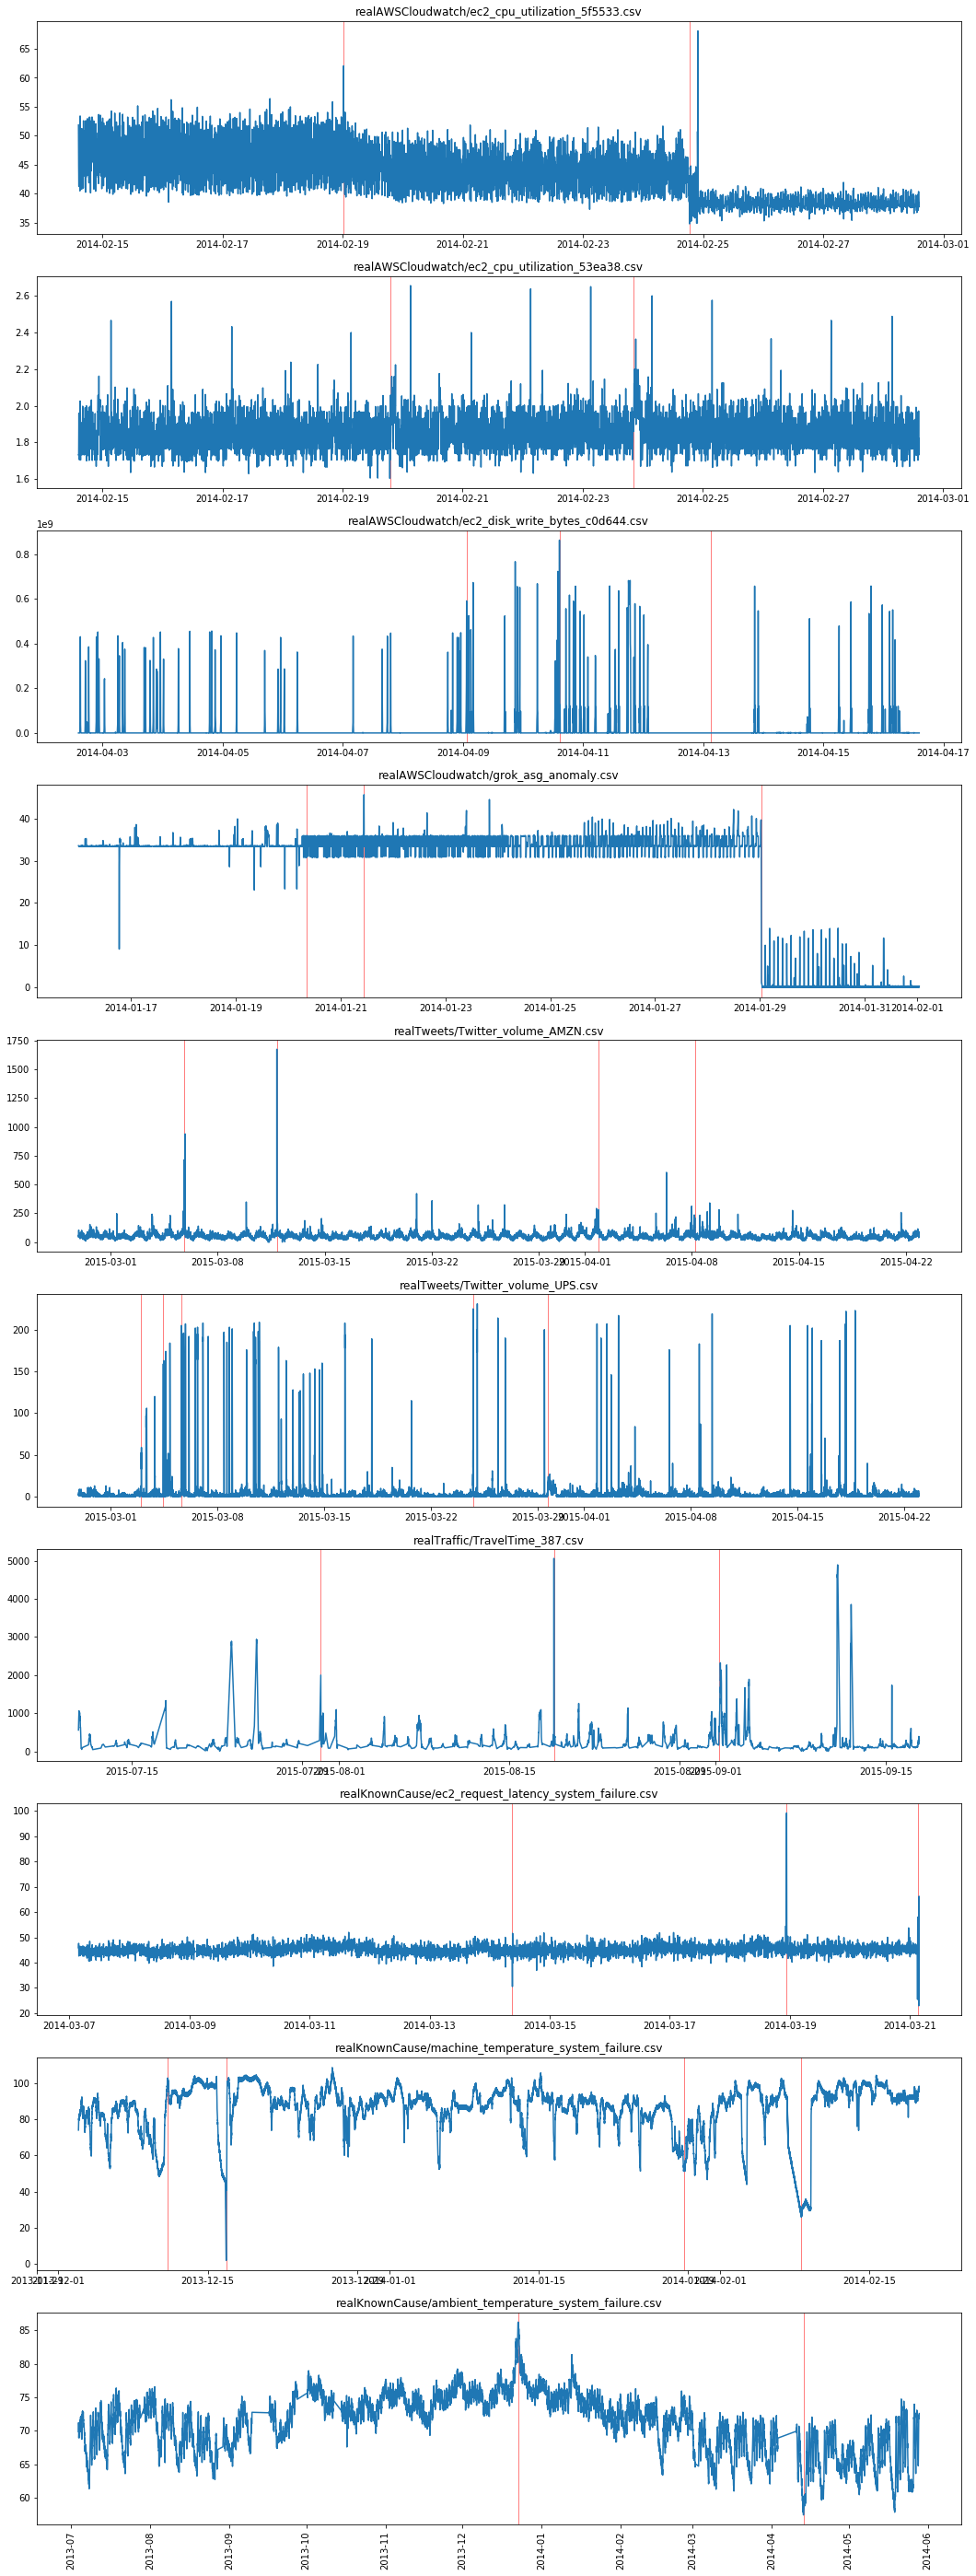

In [5]:
helper.plot_metrics(metric_map, figsize=(18, 50))

## Anomaly Definition

From the charts above I can define anomaly as follows:
- Sudden metric value spike or collapse
- Sudden change in variance
- Sudden level shift
- Any combination of the above
- It does not have any seasonal component or trend


Anomalies are extremely rare events, there are only 2-3 of them in each time series. Obviously this will cause class disbalance issues during training where it is easier for a model to classify as "No Anomaly" and still get 99.99% accuracy.

## 3 Data Preprocessing and Feature Engineering

Before extracting features from time series it is always a good practice to perform data cleaning and preprocessing.

I have chosen 4 time series from different domains for further analysis.
- EC2 request latency system failure
- EC2 CPU utilization anomaly
- Twitter volume Amazon
- Machine temperature system failure

In [12]:
ec2_request_latency_system_failure_file = "realKnownCause/ec2_request_latency_system_failure.csv"
ec2_cpu_utilization_failure_file = "realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv" 
Twitter_volume_AMZN_file = "realTweets/Twitter_volume_AMZN.csv"
machine_temperature_system_failure_file = "realKnownCause/machine_temperature_system_failure.csv"

raw_datasets = {
   "ec2_request_latency_system_failure" : metric_map[ec2_request_latency_system_failure_file],
   "ec2_cpu_utilization_5f5533" : metric_map[ec2_cpu_utilization_failure_file],
   "Twitter_volume_AMZN": metric_map[Twitter_volume_AMZN_file],
   "machine_temperature_system_failure": metric_map[machine_temperature_system_failure_file]
}

input_variables = ['y']
output_variable = 'label'

In [13]:
dataset_id = "ec2_request_latency_system_failure"
# dataset_id = "ec2_cpu_utilization_5f5533"
# dataset_id = "Twitter_volume_AMZN"
# dataset_id = "machine_temperature_system_failure"
roll_shift = 20

### 3.1 Preprocessing

The following preprocessing steps are executed:
1. Cleaning from missing values
2. Aggregating into 5 minute buckets.
3. If there are missing values after aggregation they are imputed using backfill and forwardfill methods.
4. Finally time series are scaled using MinMaxScaler

The result dataset is ready for feature engineering. 

In [14]:

preprocessor = TimeSeriesPreprocessor(
    window_size_seconds = 7200 * 3,
    window_shift = 300,
    horizon_shift_seconds = 3600,
    probe_period_seconds = 300,
    scaler = MinMaxScaler())

series = preprocessor.prepare_series(raw_datasets[dataset_id],
        input_vars = input_variables, output_vars = [output_variable],
        numeric_vars = input_variables, auto_impute = input_variables)


In [15]:
series.head()

,timestamp,y,label
0,2014-03-07 03:41:00,0.301163,0.0
1,2014-03-07 03:46:00,0.323916,0.0
2,2014-03-07 03:51:00,0.258117,0.0
3,2014-03-07 03:56:00,0.303283,0.0
4,2014-03-07 04:01:00,0.289694,0.0


### 3.2 Automatic Feature Engineering

Feature extraction and engineering is laborious process that takes considerable amount of time therefore I am performing it automatically. 

For this purpose I will use [tsfresh](https://tsfresh.readthedocs.io/en/latest/) library that performs automatic feature extraction of around [700 features](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) and then execute statistical tests to select only those features that are relevant for the classification task. 
The example of the features that it calculates are:
- The mean of time series
- The mean over the differences between subsequent time series values
- The absolute energy of the time series which is the sum over the squared values
- The kurtosis (calculated with the adjusted Fisher-Pearson standardized moment coefficient G2).

More details on what it does under the hood I am forwarding the reader to the official documentation on [feature extraction](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html) and [feature filtering](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html)

The feature extraction is performed from rolling windows. I would like to understand how the window size influences the performance of the classifier therefore I am extracting features from windows of different sizes - from 5 to 35 points. This point range corresponds to the time interval 25 to 175 minutes.

In [16]:
feature_engineering = TimeSeriesFeatureEngineering(
      x_columns = input_variables,
      roll_shift = roll_shift,
      ts_variable = 'timestamp',
      y_column = output_variable)

In [18]:
dataset = feature_engineering.make_features(series)
dataset.to_csv(f"anomaly/{dataset_id}_{roll_shift}.csv")

In [19]:
dataset.head()

variable,"y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","y__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8",y__range_count__max_1__min_-1,y__ratio_beyond_r_sigma__r_3,y__number_crossing_m__m_0,y__value_count__value_1,"y__fft_aggregated__aggtype_""skew""","y__fft_aggregated__aggtype_""kurtosis""","y__fft_aggregated__aggtype_""centroid""",y__standard_deviation,...,"y__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""",y__energy_ratio_by_chunks__num_segments_10__segment_focus_3,"y__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_5",y__partial_autocorrelation__lag_6,"y__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5","y__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""",y__autocorrelation__lag_5,"y__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","y__agg_autocorrelation__f_agg_""mean""__maxlag_40",label
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,2.738238,9.111801,0.000000,0.000000,...,0.000026,0.000000,0.448393,-0.115668,0.481805,0.328655,-0.114006,-0.004044,0.000000,0.0
1,0.0,0.0,2.0,0.0,0.0,0.0,2.738238,9.111801,0.035122,0.011377,...,0.000026,0.000000,0.448393,-0.115668,0.481805,0.328655,-0.114006,-0.004044,-1.000000,0.0
2,0.0,0.0,3.0,0.0,0.0,0.0,2.738238,9.111801,0.061504,0.027285,...,0.000026,0.000000,0.448393,-0.115668,0.481805,0.328655,-0.114006,-0.004044,-0.457412,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,2.738238,9.111801,0.140980,0.023941,...,0.000026,0.259667,0.448393,-0.115668,0.481805,0.328655,-0.114006,-0.004044,-0.209808,0.0
4,0.0,0.0,5.0,0.0,0.0,0.0,2.738238,9.111801,0.107934,0.021592,...,0.000026,0.209931,0.448393,-0.115668,0.481805,0.328655,-0.114006,-0.004044,-0.174693,0.0


## 4 Model training

In [20]:
all_window_sizes = [5, 10, 15, 20, 25, 30, 35]
def load_datasets():
    feature_datasets = {}
    for dataset_id in raw_datasets.keys():
        feature_datasets[dataset_id] = {}
        for window_size in all_window_sizes:
            feature_datasets[dataset_id][window_size] = pd.read_csv(f"anomaly/{dataset_id}_{window_size}.csv")
    return feature_datasets

feature_datasets = load_datasets()

I am splitting the dataset to train/validation/test sets as always in such cases:


In [21]:
def training_dataset(dataset):
    train_test_split_ratio = 0.2
    train_valid_split_ratio = 0.2
    seed = 42

    input_features = list(dataset.columns)
    input_features.remove(output_variable)

    X_train, X_test, y_train, y_test = train_test_split(dataset[input_features], dataset[output_variable], test_size=train_test_split_ratio, random_state = seed)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = train_valid_split_ratio, random_state = seed)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


### 4.1 Training Gradient Boosting tree model

I am going to train Gradient Boosting Tree as a classifier. This type of model has very good performance although it is also prone to overfitting.

In [22]:
model = XGBoostModel()

dataset = feature_datasets["ec2_request_latency_system_failure"][20]
X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)

model.fit(X_train.as_matrix(), y_train.as_matrix(), X_valid.as_matrix(), y_valid.as_matrix())

Y_train_pred = model.predict(X_train.as_matrix())
helper.print_results("Training", helper.evaluate(y_train, Y_train_pred))

Y_valid_pred = model.predict(X_valid.as_matrix())
helper.print_results("Validation", helper.evaluate(y_valid, Y_valid_pred))

y_test_pred = model.predict(X_test.as_matrix())
helper.print_results("Test", helper.evaluate(y_test, y_test_pred))



Training metrics:
confusion matrix: 
[[2550    1]
 [   0   29]]
average_precision_score:  0.9666666666666667
f1_score:  0.983050847457627

Validation metrics:
confusion matrix: 
[[640   0]
 [  0   6]]
average_precision_score:  1.0
f1_score:  1.0

Test metrics:
confusion matrix: 
[[793   0]
 [  0  14]]
average_precision_score:  1.0
f1_score:  1.0


Not bad considering the fact that there is only ~1 % positive samples.  

The result overview over all 4 series is given below:

| F1 scores                   | training | validation | test |
|-----------------------------|----------|------------|------|
| request latency failure     | 0.98     | 1.0        | 1.0  |
| cpu utilization failure     | 0.68     | 0.62       | 0.47 |
| twitter volume AMZN         | 0.83     | 0.74       | 0.61 |
| Machine temperature failure | 0.60     | 0.60       | 0.5  |

It seems that in certain cases the classifier a bit overfits the data.
It is also noticeable that performance is not great on some datasets and from confusion matrix it looks like classifier tends to infer "not an anomaly" quite often.

### 4.2 Fixing Class Disbalance with Synthetic Minority Oversampling

As it was expected the anomalies are quite rare therefore one of the big challenges in machine learning of anomalous time series is how to train classifier and achieve decent performance with only a few anomalous samples.

In order to fix the class disbalance I am going to artificially increase the number of anomalous samples by using [Synthetic Minority Over-sampling Technique](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html). 
SMOTE synthesizes new samples for the minority class using several neighbouring samples of the same class. This will allow to balance the number of positive and negative samples and avoid cheap wins like always classify as "Not a anomaly".

The code and results of those experiments are given below:

In [23]:
dataset = feature_datasets["ec2_request_latency_system_failure"][20]

X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)

print("class distribution in original training data.\n", y_train.groupby(by=lambda v: y_train.loc[v]).count())
X_upsampled, y_upsampled = feature_engineering.class_imbalance_fix(X_train, y_train, ratio=0.05)
elements, counts_elements = np.unique(y_upsampled, return_counts=True)
print("class distribution in upsampled training data.")
print(elements)
print(counts_elements)

model = XGBoostModel()
model.fit(X_upsampled, y_upsampled, X_valid.as_matrix(), y_valid.as_matrix())

Y_train_pred = model.predict(X_train.as_matrix())
helper.print_results("Training", helper.evaluate(y_train, Y_train_pred))

Y_valid_pred = model.predict(X_valid.as_matrix())
helper.print_results("Validation", helper.evaluate(y_valid, Y_valid_pred))

y_test_pred = model.predict(X_test.as_matrix())
helper.print_results("Test", helper.evaluate(y_test, y_test_pred))


class distribution in original training data.
 0.0    2551
1.0      29
Name: label, dtype: int64
class distribution in upsampled training data.
[0. 1.]
[2551  127]

Training metrics:
confusion matrix: 
[[2550    1]
 [   0   29]]
average_precision_score:  0.9666666666666667
f1_score:  0.983050847457627

Validation metrics:
confusion matrix: 
[[640   0]
 [  0   6]]
average_precision_score:  1.0
f1_score:  1.0

Test metrics:
confusion matrix: 
[[793   0]
 [  0  14]]
average_precision_score:  1.0
f1_score:  1.0


It looks like with the increasing of the number of positive samples using SMOTE our model perform slightly better.

| F1 scores                   | training | validation | test |
|-----------------------------|----------|------------|------|
| request latency failure     | 0.98     | 1.0        | 1.0  |
| cpu utilization failure     | 0.94     | 0.66       | 0.8  |
| twitter volume AMZN         | 0.75     | 0.51       | 0.65 |
| Machine temperature failure | 0.58     | 0.51       | 0.44 |


The synthetic samples improve f1score on around 5-20%. But it also looks like the total number of samples matters. I am going to look in more detail on relationship between synthetic minority ratio and classifier performance in further sections.


### 4.3 What is the best ratio of synthetic samples

In the experiments below the classifer is trained using datasets with different syntetic minority ratio from 0 to 1.0.
Let's investigate which syntetic minority ratio is the best for classifier's performance.

In [24]:
def calculate_metrics(dataset): 
    X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)
    f1scores = []
    precisions = []
    recalls = []
    ratios = []    
    for i in range(0, 21):
        ratio = float(i) / 20.0
        if i > 0:            
            X_upsampled, y_upsampled = feature_engineering.class_imbalance_fix(X_train, y_train, ratio = ratio)
        else:
            X_upsampled, y_upsampled = X_train.as_matrix(), y_train.as_matrix()

        model = XGBoostModel()
        model.fit(X_upsampled, y_upsampled, X_valid.as_matrix(), y_valid.as_matrix())

        y_test_pred = model.predict(X_test.as_matrix())
        result = helper.evaluate(y_test, y_test_pred)
        f1_score = result["f1_score"]
        precision = result["precision"]
        recall = result["recall"]
        f1scores.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)
        ratios.append(ratio)
    return f1scores, precisions, recalls, ratios

def classifier_performance_vs_syntetic_minority_ratio():
    all_f1scores = {}
    all_precisions = {}
    all_recalls = {}
    ratios = []
    window_size = 20

    for dataset_id in feature_datasets.keys():
        f1scores, precisions, recalls, ratios = calculate_metrics(feature_datasets[dataset_id][window_size])
        all_precisions[dataset_id] = precisions
        all_recalls[dataset_id] = recalls
        all_f1scores[dataset_id] = f1scores
    return all_f1scores, all_precisions, all_recalls, ratios

all_f1scores_ratio, all_precisions_ratio, all_recalls_ratio, ratios = \
    classifier_performance_vs_syntetic_minority_ratio()

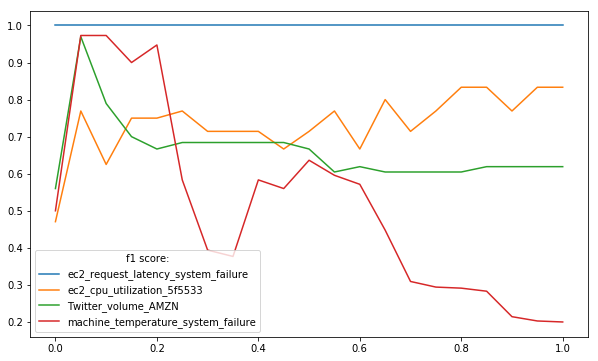

In [25]:
def plot_metrics(name, scores, ratios):
    plt.figure(figsize=(10, 6))
    for dataset_id in scores.keys():
        plt.plot(ratios, scores[dataset_id], label=dataset_id)        
        plt.legend(title=f'{name}:')
        
plot_metrics("f1 score", all_f1scores_ratio, ratios)

The chart above shows f1score for different synthetic minority ratios. It is clear that there is a peak in range [0.05..0.2]. It means that it is enough to oversample only a tiny fraction of minority set, otherwise the performance of the classifier degrades and it overfits.

### 4.4 How ratio of synthetic samples impacts the number of false negatives and false positives

The charts below show the relationship between precision/recall vs oversampling minority ratio. It is clear that increasing the ratio of synthetic minority has generally positive effect on classifier performance in comparison when there is no oversampling. The relationship is very similar to f1score vs smote ratio: there is a peak in the range [0.05..0.2].


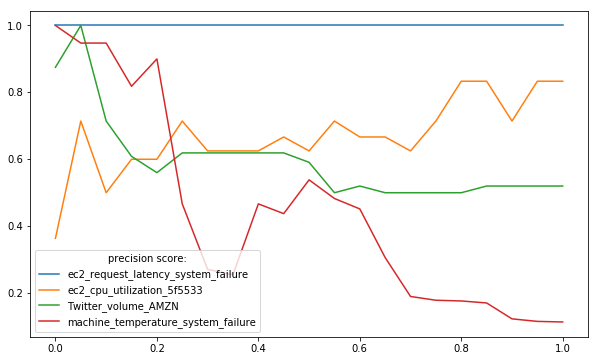

In [26]:
plot_metrics("precision score", all_precisions_ratio, ratios)

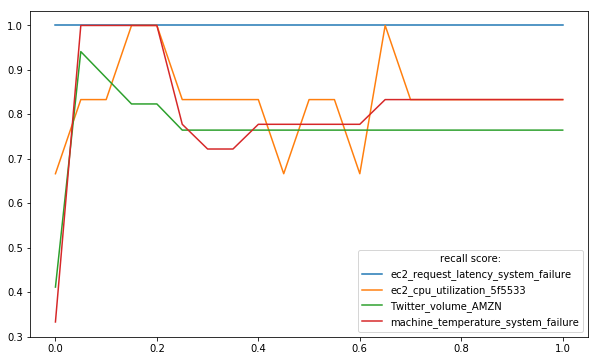

In [27]:
plot_metrics("recall score", all_recalls_ratio, ratios)

### 4.5 How window size impacts the classifier performance

Another question I'd like get answer for is how the number of points in window impacts the classifier performance. I am expecting that more points could have positive impact on the performance of the classifier.

In [28]:
def train_and_test(dataset, ratio): 
    X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)
    
    model = XGBoostModel()
    if ratio > 0.0:
        X_upsampled, y_upsampled = feature_engineering.class_imbalance_fix(X_train, y_train, ratio = ratio)
    else:
        X_upsampled, y_upsampled = X_train.as_matrix(), y_train.as_matrix()        
    model.fit(X_upsampled, y_upsampled, X_valid.as_matrix(), y_valid.as_matrix())

    y_test_pred = model.predict(X_test.as_matrix())
    
    result = helper.evaluate(y_test, y_test_pred)
    
    return result["f1_score"], result["precision"], result["recall"]

def classifier_performance_given_window_size(sm_ratio):
    all_f1scores = {}
    all_precisions = {}
    all_recalls = {}
    
    for dataset_id in feature_datasets.keys():
        all_f1scores[dataset_id] = []
        all_precisions[dataset_id] = []
        all_recalls[dataset_id] = []

        for window_size in all_window_sizes:
            f1score, precision, recall = train_and_test(feature_datasets[dataset_id][window_size], sm_ratio)
            all_f1scores[dataset_id].append(f1score)
            all_precisions[dataset_id].append(precision)
            all_recalls[dataset_id].append(recall)
    return all_f1scores, all_precisions, all_recalls

all_f1scores, all_precisions, all_recalls = classifier_performance_given_window_size(sm_ratio=0.0)
all_f1scores_sm, all_precisions_sm, all_recalls_sm = classifier_performance_given_window_size(sm_ratio=0.05)

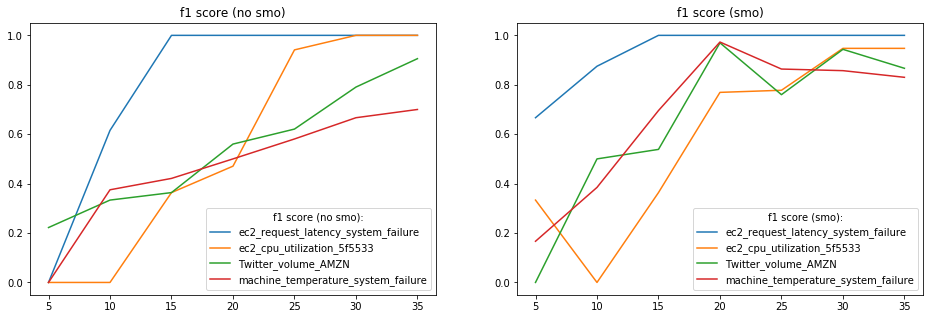

In [29]:
def plot_2_graphs(name1, name2, scores1, scores2, ratios):
    fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(16, 5))
    def subplot(ax, name, scores, x):        
        ax.set_title(name)
        for dataset_id in scores.keys():
            ax.plot(x, scores[dataset_id], label=dataset_id)        
        ax.legend(title=f'{name}:')
    subplot(axes[0][0], name1, scores1, ratios)
    subplot(axes[0][1], name2, scores2, ratios)

plot_2_graphs("f1 score (no smo)", "f1 score (smo)", all_f1scores, all_f1scores_sm, all_window_sizes)

The left chart shows the relationship between window size and f1 score without minority oversampling and the right chart with minority oversampling. 

As it was expected - the more points are in window the better classifier is.

The impact of oversampling has positive effect on the model so the number of points in window can be reduced from 35 to 20. In the real production system this could mean practically reduction of issue detection time almost in half.

### 4.6 How window size impacts the number of false negatives and false positives

The relationship between precision/recall and window size is similar to f1 score: the more points the better classifier is. It makes sense to make window greater than 20-25 points.

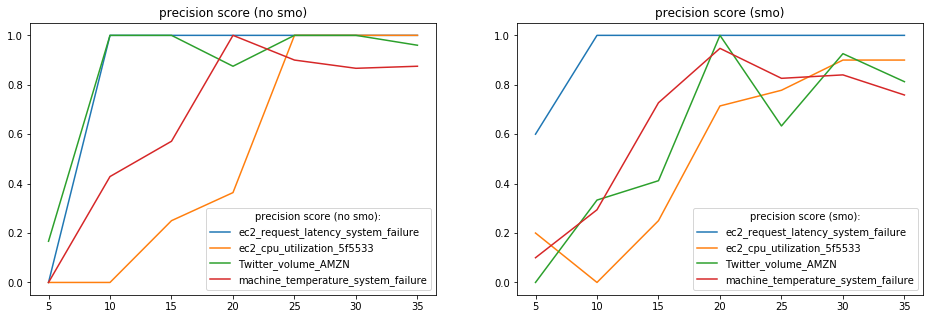

In [30]:
plot_2_graphs("precision score (no smo)", "precision score (smo)", \
              all_precisions, all_precisions_sm, all_window_sizes)

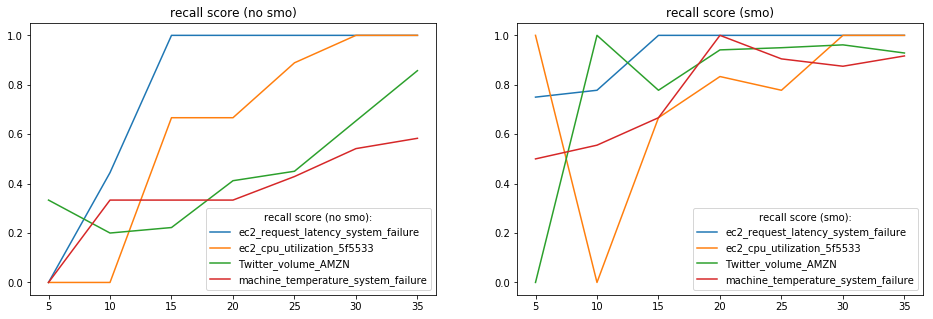

In [31]:
plot_2_graphs("recall score (no smo)", "recall score (smo)", \
              all_recalls, all_recalls_sm, all_window_sizes)

## 5 Conclusions and Future Work

Time series classification is an important task in detecting operational problems and root cause analysis.

Anomalies in time series are relatively infrequent but may cause serious problems. Detecting and classifying anomalies in time series is difficult because of extremely low number of anomalous samples. 

In order to perform anomaly detection the researcher will face the number of issues. Firstly it is required to use effective mechanism to do feature extraction and feature selection from time series. This can be effectively solved using frameworks such as **tsfresh** which extracts different statistical features and selects only those that are statistically significant using null hypothesis tests. The next problem is class disbalance which can be solved using  synthetic minority oversamling that increases the performance of the classifier. The other problem not covered in this notebook is confidence in the classifier trained with only few samples in one of the classes. Can we trust the classifier that trained in this way? I am leaving investigation of this matter for future work.


## 6 References

1. [Source for this notebook](https://github.com/ktatarnikov/time-series/blob/master/notebooks/Classification%20of%20Anomalous%20TimeSeries.ipynb)
2. [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/boltzmannbrain/nab)
3. [tsfresh](https://github.com/blue-yonder/tsfresh)
4. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
